In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
import random
%matplotlib inline
import cv2
import os
from subprocess import call

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
def get_measure_note(thickness = 3, height = 45, width = 10):
    measure_note = np.zeros([height,width])
    length = random.randint(height-3,height)
    measure_note[0:length, int(width/2):int(width/2)+thickness] = 255
    rows,cols = measure_note.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-5,5),random.random()*0.12 + 0.95)
    measure_note = cv2.warpAffine(measure_note,M,(cols,rows))
    measure_note = cv2.GaussianBlur(measure_note,(3,3),0)
    return measure_note

In [6]:
def get_rest_bar(thickness = 3, height = 45, width = 10):
    rest_bar = np.zeros([height,width])
    length = random.randint(43,45)
    rest_bar[int(height/2)-1:int(height/2)+thickness-1, 0:10 - random.randint(0,2)] = 255
    rows,cols = rest_bar.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-4,10),random.random()*0.12 + 0.95)
    rest_bar = cv2.warpAffine(rest_bar,M,(cols,rows))
    rest_bar = cv2.GaussianBlur(rest_bar,(3,3),0)
    return rest_bar

In [7]:
def get_note(last_digit = -1, can_zero=True):
    canvass = np.zeros([45,28])
    index = random.randint(0,x_train.shape[0]-1)
    while y_train[index] > 7 or y_train[index] == last_digit or (not can_zero and y_train[index] == 0):
        index = random.randint(0,x_train.shape[0]-1)
    canvass[4:32,:] = x_train[index]
    label = y_train[index]
    level_vote = random.randint(0,2)
    if level_vote == 0 or label == 0:
        return canvass, label
    
    if level_vote == 1:
        canvass[0:3,12:15] = 255
        canvass[0:5,11:16] = cv2.GaussianBlur(canvass[0:5,11:16],(3,3),0)
        return canvass, label + 10
    
    if level_vote == 2:
        canvass[41:44,12:15] = 255
        canvass[40:44,11:16] = cv2.GaussianBlur(canvass[40:44,11:16],(3,3),0)
        return canvass, label + 20

In [8]:
def get_box(canvass, base_coord=[0,0], show_graph = False):
    top_boundary = 0
    bottom_boundary = canvass.shape[0]-1
    left_boundary = 0
    right_boundary = canvass.shape[1]-1
    for i in range(canvass.shape[0]):
        for j in range(canvass.shape[1]):
            if canvass[i][j]:
                bottom_boundary = i
                break
                
    for i in reversed(range(canvass.shape[0])):
        for j in range(canvass.shape[1]):
            if canvass[i][j]:
                top_boundary = i
                break
    for i in range(canvass.shape[1]):
        for j in range(34):
            if canvass[j][i]:
                right_boundary = i
                break
                
    for i in reversed(range(canvass.shape[1])):
        for j in range(34):
            if canvass[j][i]:
                left_boundary = i
                break
    #canvass[top_boundary:bottom_boundary,left_boundary:left_boundary+1] = 255
    #canvass[top_boundary:bottom_boundary,right_boundary-1:right_boundary] = 255
    #canvass[top_boundary:top_boundary+1,left_boundary:right_boundary] = 255
    #canvass[bottom_boundary-1:bottom_boundary,left_boundary:right_boundary] = 255
    if show_graph:
        plt.imshow(canvass)
    return [top_boundary + base_coord[0], left_boundary + base_coord[1], bottom_boundary + base_coord[0], right_boundary + base_coord[1]]

In [9]:
def get_combination(last_digit, simple_version = False):
    #1 * 1/4, 2 * 1/8, 1 * 1/8 + 2 * 1/16,  2 * 1/16 + 1/8, 4 * 1/16 
    index = random.randint(1,10)
    if simple_version:
        index = True
    if index <= 6:
        # 1 * 1/4
        seed = random.randint(1,2)
        c, label =  get_note(last_digit=last_digit)
        return c, [str(label) + "_4"], [get_box(c)], label
    if index == 7:
        # 2 * 1/8
        img1, label1 = get_note(last_digit=last_digit)
        img2, label2 = get_note(label1)
        c = np.hstack((img1, img2))
        c[34:36, 5:55] = 255
        rows = 3
        cols = 51
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-4,4),random.random()*0.12 + 0.95)
        c[34:37, 4:55] = cv2.warpAffine(c[34:37, 4:55],M,(cols,rows))
        return c, [str(label1) + '_8',str(label2) + '_8'], [get_box(img1), get_box(img2,[0, img1.shape[1]])],  label2
        
    if index == 8:
        #2 * 1/16 + 1/8
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        c = np.hstack((img1, img2, img3))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 5:52] = 255
        rows = 8
        cols = c.shape[1] - 9
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(1,3),1)
        c[32:40, 4:c.shape[1]-5] = cv2.warpAffine(c[32:40, 4:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_16',str(label2) + '_16', str(label3) + '_8'],  [get_box(img1), get_box(img2,[0, img1.shape[1]]), get_box(img3,[0, img1.shape[1] + img2.shape[1]])], label3
    
    if index == 9:
        #1/8 + 2 * 1/16
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        c = np.hstack((img1, img2, img3))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 35:c.shape[1]-5] = 255
        rows = 8
        cols = c.shape[1] - 9
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(1,3),1)
        c[32:40, 4:c.shape[1]-5] = cv2.warpAffine(c[32:40, 4:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_8',str(label2) + '_16', str(label3) + '_16'],  [get_box(img1), get_box(img2,[0, img1.shape[1]]), get_box(img3,[0, img1.shape[1] + img2.shape[1]])], label3
    if index == 10:
        #4 * 1/16
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        [img4, label4] = get_note(label3)
        c = np.hstack((img1, img2, img3, img4))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 5:c.shape[1]-5] = 255
        rows = 8
        cols = 102
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-1,1),1)
        c[31:39, 5:c.shape[1]-5] = cv2.warpAffine(c[32:39, 5:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_16',str(label2) + '_16', str(label3) + '_16', str(label4) + '_16'],  [get_box(img1), get_box(img2,[0, img1.shape[1]]), get_box(img3,[0, img1.shape[1] + img2.shape[1]]), get_box(img4, [0, img1.shape[1] + img2.shape[1] + img3.shape[1]])], label4

In [25]:
def get_line(max_width, measure_capacity = 2, simple_version = False, try_num = 3, padding = 50):
    canvass = np.zeros([45, padding])
    labels = []
    last_digit = -1
    locs = []
    curr_width = canvass.shape[1]
    while True:
        new_canvasses, new_labels, new_locs, last_digit = get_combination(last_digit, simple_version=simple_version)
        for i in range(len(new_locs)):
            new_locs[i][1] += canvass.shape[1]
            new_locs[i][3] += canvass.shape[1]
           
        remained_measure = measure_capacity - 1
        while remained_measure:
            new_canvass, new_label, new_loc, last_digit = get_combination(last_digit, simple_version=simple_version)
            for i in range(len(new_loc)):
                new_loc[i][1] += new_canvasses.shape[1] + canvass.shape[1]
                new_loc[i][3] += new_canvasses.shape[1] + canvass.shape[1]
            new_canvasses = np.hstack((new_canvasses, new_canvass))
            new_locs += new_loc
            new_labels += new_label
            remained_measure -= 1
        
        #new_measure_note = get_measure_note()
        #new_labels += '|'
        #new_loc = get_box(new_measure_note, [0, new_canvasses.shape[1] + canvass.shape[1]])
        #new_canvasses = np.hstack((new_canvasses, new_measure_note))
        #new_locs += [new_loc]
        if new_canvasses.shape[1] + canvass.shape[1] > max_width:
            if try_num == 0:
                break
            try_num -=1
            continue
        canvass = np.hstack((canvass, new_canvasses))
        labels += new_labels
        curr_width += new_canvass.shape[1]
        locs += new_locs
    canvass = np.hstack((canvass, np.zeros([45, max_width - canvass.shape[1]])))
    return canvass, locs, labels

[[10, 54, 27, 73], [0, 82, 28, 101], [7, 115, 26, 128], [0, 142, 28, 155], [0, 167, 26, 184], [11, 198, 43, 217], [9, 222, 43, 240], [0, 252, 28, 265], [8, 278, 27, 297], [9, 311, 43, 324], [10, 335, 27, 354], [9, 366, 28, 377]]
['0_4', '13_16', '6_16', '14_16', '12_16', '25_4', '25_4', '13_4', '0_16', '25_16', '0_16', '1_16']


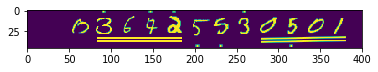

In [26]:
[canvass, locs, labels] = get_line(400)
print(locs)
print(labels)
plt.imshow(canvass)

In [27]:
def get_page(music_sheet_dir, label_dir, max_height, max_width, measure_capacity, padding = 30, inner_line_spacing = 60, show_image = True, simple_version = False, save=False):
    canvass = np.zeros([padding, max_width])
    locs = []
    labels = []
    curr_height = canvass.shape[0]
    while curr_height < max_height:
        new_canvass1 = np.zeros([inner_line_spacing, max_width])
        new_canvass2, new_locs, new_labels = get_line(max_width, measure_capacity, simple_version, padding=padding)
        new_canvass = np.vstack((new_canvass1, new_canvass2))
        if curr_height + new_canvass.shape[0] + padding > max_height:
            break
        for i in range(len(new_locs)):
            new_locs[i][0] += canvass.shape[0] + inner_line_spacing
            new_locs[i][2] += canvass.shape[0] + inner_line_spacing
        canvass = np.vstack((canvass, new_canvass))
        labels += new_labels
        locs += new_locs
        curr_height += new_canvass.shape[0] + inner_line_spacing
    canvass = np.vstack((canvass, np.zeros([max_height - canvass.shape[0], max_width])))
    if save:
        cv2.imwrite(music_sheet_dir, canvass)
    label_array = np.column_stack([np.array(locs), np.array(labels)])
    if show_image:      
        plt.imshow(canvass)
        
    if save:
        with open(label_dir, 'a+') as fp:
            for i in range(len(labels)):
                fp.write(music_sheet_dir + ',' + ','.join(str(e) for e in locs[i]) + ',' + str(labels[i])  + '\n')
    return canvass, labels, locs

[[99, 35, 133, 54], [98, 61, 117, 80], [90, 96, 118, 105], [99, 125, 118, 134], [99, 147, 114, 166], [90, 171, 121, 190], [99, 207, 133, 218], [98, 232, 133, 251], [203, 38, 222, 51], [195, 66, 222, 79], [204, 94, 223, 107], [203, 117, 238, 136], [205, 151, 224, 162], [205, 176, 224, 195], [195, 202, 226, 219], [201, 232, 238, 248], [306, 35, 343, 52], [307, 66, 343, 79], [308, 91, 327, 107], [300, 117, 328, 136], [307, 150, 343, 162], [306, 177, 325, 192], [300, 202, 326, 219], [309, 233, 328, 250], [300, 261, 325, 276]]


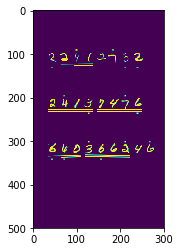

In [28]:
canvass, labels, locs = get_page('sheet.png', 'label.txt', 500, 300, 2)
print(locs)

In [29]:
def generate_music_sheet(num, music_sheet_dir, music_label_dir, height, width, inner_line_spacing, padding, simple_version, measure_capacity = 2):
    curr = 0
    call(["rm", "-rf", music_sheet_dir])
    call(["rm", "-rf", music_label_dir])
    if not os.path.isdir(music_sheet_dir):
        
        os.makedirs(music_sheet_dir)
    if not os.path.isdir(music_label_dir):
        
        os.makedirs(music_label_dir)
    while curr < num:
        sheet_dir = music_sheet_dir + 'img' + str(curr) + '.png'
        label_dir = music_label_dir + 'label' + str(curr) + '.txt'
        get_page(sheet_dir,label_dir,height,width,measure_capacity, show_image=False, simple_version=simple_version)
        curr += 1
        print('Progress: ' + "{0:.0f}%".format(curr / num * 100) )

10579
10579


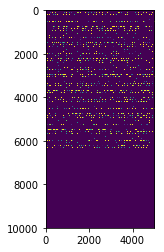

In [30]:
def roi_pooling(canvass, locs, normalized_size = (28,28)):
    global_count = 0
    res = []
    img_root_dir = '../dataset/sheet/training/img'
    for loc in locs:
        img_dir= img_root_dir + str(global_count) + '.png'
        normalized_image = cv2.resize(canvass[loc[0]:loc[2], loc[1]:loc[3]], normalized_size)
        res.append(normalized_image)
        cv2.imwrite(img_dir, normalized_image)
        global_count += 1
    return res
canvass, labels, locs = get_page('sheet.png', 'label.txt', 10000, 5000, 2, simple_version = False)
print(len(locs))
normalized_imgs = roi_pooling(canvass, locs)
print(len(labels))

In [31]:
from keras.utils import to_categorical
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adagrad
import keras
from keras import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [32]:
train_ratio = 0.9
normalized_imgs = np.array(normalized_imgs)
train_img = normalized_imgs[:int(train_ratio*len(normalized_imgs)), :, :]
test_img = normalized_imgs[int(train_ratio*len(normalized_imgs)):, :, :]
train_y = np.array(labels[:int(train_ratio*len(normalized_imgs))])
test_y = np.array(labels[int(train_ratio*len(normalized_imgs)):])
train_img = np.expand_dims(train_img, axis=3)
test_img = np.expand_dims(test_img, axis=3)

In [33]:
encoder = LabelEncoder()
encoder.fit(labels)
train_y_encoded = encoder.transform(train_y)
test_y_encoded = encoder.transform(test_y)
train_y_encoded_cat = np_utils.to_categorical(train_y_encoded)
test_y_encoded_cat = np_utils.to_categorical(test_y_encoded)

In [34]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

In [35]:
history = AccuracyHistory()

In [36]:
label_count = {}
for label in labels:
    if not label in label_count:
        label_count[label] = 0
    label_count[label] +=1

In [37]:
label_count

{'13_4': 135,
 '27_4': 156,
 '11_8': 117,
 '15_8': 108,
 '17_8': 97,
 '21_16': 210,
 '7_16': 209,
 '23_16': 176,
 '23_8': 91,
 '25_8': 82,
 '7_8': 111,
 '0_16': 535,
 '16_16': 208,
 '15_16': 199,
 '27_16': 212,
 '1_16': 218,
 '25_16': 179,
 '14_16': 192,
 '16_8': 97,
 '5_4': 135,
 '26_8': 98,
 '11_4': 178,
 '0_4': 417,
 '25_4': 134,
 '16_4': 151,
 '22_8': 90,
 '1_8': 110,
 '12_16': 190,
 '2_4': 150,
 '15_4': 162,
 '22_16': 199,
 '17_16': 203,
 '13_16': 207,
 '11_16': 219,
 '27_8': 103,
 '24_16': 176,
 '1_4': 170,
 '23_4': 145,
 '13_8': 94,
 '14_4': 133,
 '0_8': 268,
 '21_8': 105,
 '7_4': 164,
 '5_16': 172,
 '24_4': 157,
 '6_16': 213,
 '3_16': 182,
 '4_16': 180,
 '21_4': 156,
 '2_16': 177,
 '4_4': 136,
 '12_8': 97,
 '3_8': 94,
 '6_8': 110,
 '22_4': 161,
 '26_4': 141,
 '12_4': 141,
 '6_4': 153,
 '14_8': 107,
 '2_8': 84,
 '4_8': 97,
 '3_4': 165,
 '26_16': 178,
 '5_8': 87,
 '17_4': 150,
 '24_8': 108}

In [38]:
list(encoder.classes_)

['0_16',
 '0_4',
 '0_8',
 '11_16',
 '11_4',
 '11_8',
 '12_16',
 '12_4',
 '12_8',
 '13_16',
 '13_4',
 '13_8',
 '14_16',
 '14_4',
 '14_8',
 '15_16',
 '15_4',
 '15_8',
 '16_16',
 '16_4',
 '16_8',
 '17_16',
 '17_4',
 '17_8',
 '1_16',
 '1_4',
 '1_8',
 '21_16',
 '21_4',
 '21_8',
 '22_16',
 '22_4',
 '22_8',
 '23_16',
 '23_4',
 '23_8',
 '24_16',
 '24_4',
 '24_8',
 '25_16',
 '25_4',
 '25_8',
 '26_16',
 '26_4',
 '26_8',
 '27_16',
 '27_4',
 '27_8',
 '2_16',
 '2_4',
 '2_8',
 '3_16',
 '3_4',
 '3_8',
 '4_16',
 '4_4',
 '4_8',
 '5_16',
 '5_4',
 '5_8',
 '6_16',
 '6_4',
 '6_8',
 '7_16',
 '7_4',
 '7_8']

In [39]:
encoder.transform(list(encoder.classes_))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [40]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(test_y_encoded_cat.shape[1], activation='softmax'))

In [41]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adagrad(lr=0.001),
              metrics=['accuracy'])

In [ ]:
model.fit(train_img, train_y_encoded_cat,
          batch_size=50,
          epochs=20,
          verbose=1,
          validation_data=(test_img, test_y_encoded_cat))

Train on 9521 samples, validate on 1058 samples
Epoch 1/20
9521/9521 [==============================] - 11s 1ms/step - loss: 2.3840 - acc: 0.3484 - val_loss: 1.4187 - val_acc: 0.4858
Epoch 2/20
9521/9521 [==============================] - 12s 1ms/step - loss: 1.5806 - acc: 0.4783 - val_loss: 1.2844 - val_acc: 0.4981
Epoch 3/20
9521/9521 [==============================] - 11s 1ms/step - loss: 1.3896 - acc: 0.5214 - val_loss: 1.2268 - val_acc: 0.5047
Epoch 4/20
9521/9521 [==============================] - 12s 1ms/step - loss: 1.2960 - acc: 0.5388 - val_loss: 1.2027 - val_acc: 0.5076
Epoch 5/20
9521/9521 [==============================] - 11s 1ms/step - loss: 1.2002 - acc: 0.5638 - val_loss: 1.1713 - val_acc: 0.5189
Epoch 6/20
9521/9521 [==============================] - 11s 1ms/step - loss: 1.1783 - acc: 0.5673 - val_loss: 1.1687 - val_acc: 0.5085
Epoch 7/20
9521/9521 [==============================] - 11s 1ms/step - loss: 1.1391 - acc: 0.5761 - val_loss: 1.1565 - val_acc: 0.5265
Epoch 8

In [86]:
score = model.evaluate(test_img, test_y_encoded_cat, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7263115182134058
Test accuracy: 0.71365313670732


In [87]:
pred = model.predict_classes(test_img)

In [88]:
np.sum(test_y_encoded == pred) / len(test_img)

0.7136531365313653

In [89]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 64)          256       
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
__________

In [90]:
import coremltools

In [91]:
def convert_model(model):
	print('converting...')
	coreml_model = coremltools.converters.keras.convert(model,input_names=['image'],image_input_names='image')
	coreml_model.author = 'YUAN SHEN'
	coreml_model.license = 'MIT'
	coreml_model.short_description = 'Reads a handwritten music note.'
	coreml_model.input_description['image'] = 'A 28x28 pixel Image'
	coreml_model.output_description['output1'] = 'A one-hot Multiarray of the music note class '
	coreml_model.save('MusicNoteClassification.mlmodel')
	print('model converted')

In [92]:
convert_model(model)

converting...
0 : conv2d_9_input, <keras.engine.topology.InputLayer object at 0x1828b13f98>
1 : conv2d_9, <keras.layers.convolutional.Conv2D object at 0x1828b13f28>
2 : conv2d_9__activation__, <keras.layers.core.Activation object at 0x182f4ccd68>
3 : max_pooling2d_9, <keras.layers.pooling.MaxPooling2D object at 0x1828b2d080>
4 : batch_normalization_4, <keras.layers.normalization.BatchNormalization object at 0x1828b2d048>
5 : conv2d_10, <keras.layers.convolutional.Conv2D object at 0x1828b2db70>
6 : conv2d_10__activation__, <keras.layers.core.Activation object at 0x182f4ccda0>
7 : max_pooling2d_10, <keras.layers.pooling.MaxPooling2D object at 0x1829f4c6d8>
8 : batch_normalization_5, <keras.layers.normalization.BatchNormalization object at 0x1828affba8>
9 : flatten_5, <keras.layers.core.Flatten object at 0x1829f33860>
10 : dense_9, <keras.layers.core.Dense object at 0x1829f33a20>
11 : dense_9__activation__, <keras.layers.core.Activation object at 0x182f4ccdd8>
12 : batch_normalization_6, 

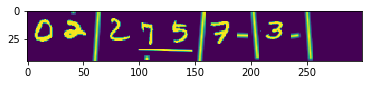

In [96]:
[canvass, locs, labels] = get_line(300,padding=0,)
plt.imshow(canvass)

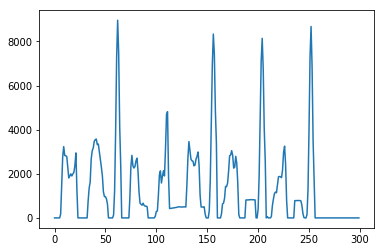

In [105]:
plt.plot(np.sum(canvass,axis=0))

In [102]:
canvass.shape

(45, 300)

In [ ]:
plt.p